In [19]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    precision_score, recall_score, f1_score
)

from imblearn.over_sampling import SMOTE
import pickle


In [20]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [21]:
selected_features = [
    "LIMIT_BAL",
    "SEX",
    "EDUCATION",
    "MARRIAGE",
    "AGE",
    "BILL_AMT1",
    "PAY_AMT1"
]

X = df[selected_features]
y = df["default.payment.next.month"]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (30000, 7)
y shape: (30000,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [23]:
print("Before SMOTE")
print("Default:", sum(y_train == 1))
print("No Default:", sum(y_train == 0))

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\nAfter SMOTE")
print("Default:", sum(y_train_res == 1))
print("No Default:", sum(y_train_res == 0))


Before SMOTE
Default: 5309
No Default: 18691

After SMOTE
Default: 18691
No Default: 18691


In [24]:
model = XGBClassifier(
    learning_rate=0.1,
    objective="binary:logistic",
    random_state=42,
    eval_metric="logloss"
)

model.fit(X_train_res, y_train_res)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [25]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Accuracy: 0.6585
ROC AUC: 0.6340488602694598
Precision: 0.31217481789802287
Recall: 0.45214770158251694
F1 Score: 0.36934441366574333


              precision    recall  f1-score   support

           0       0.82      0.72      0.77      4673
           1       0.31      0.45      0.37      1327

    accuracy                           0.66      6000
   macro avg       0.57      0.58      0.57      6000
weighted avg       0.71      0.66      0.68      6000



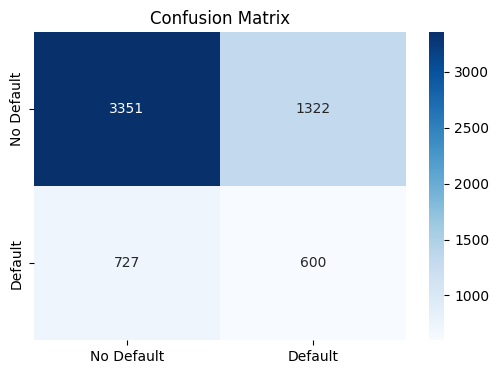

In [26]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix")
plt.show()


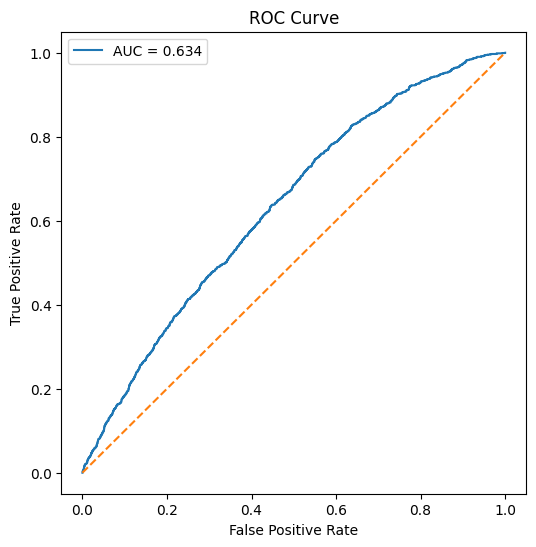

In [27]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()


<Figure size 800x500 with 0 Axes>

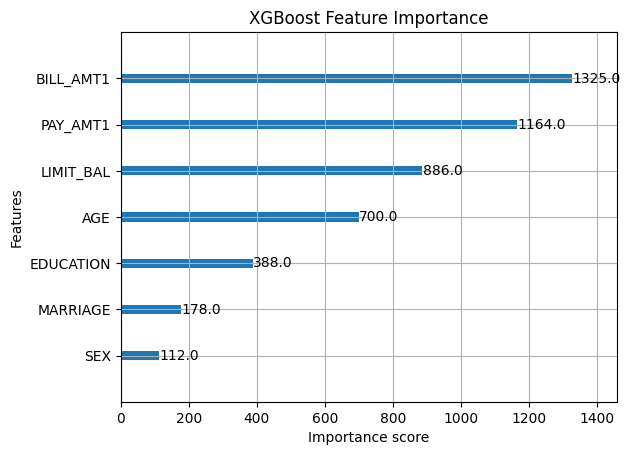

In [28]:
plt.figure(figsize=(8,5))
plot_importance(model)
plt.title("XGBoost Feature Importance")
plt.show()


In [29]:
with open("model.pkl", "wb") as file:
    pickle.dump(model, file)

print("model.pkl berhasil dibuat (versi Streamlit)")


model.pkl berhasil dibuat (versi Streamlit)
